In [51]:
import pandas as pd

# Define column names for footfall data
footfall_columns = [
    "National Park", "Month", "Year", "Footfall",
    "Concessioner Lodging", "NPS Campgrounds", "NPS Backcountry", "NPS Miscellaneous"
]

# Load footfall data (without headers)
footfall_df = pd.read_csv("footfall-stats-california-national-parks.csv", header=None, names=footfall_columns)
footfall_df['National Park'] = footfall_df['National Park'].str.replace(r' NP$', '', regex=True)

footfall_df.head()


,National Park,Month,Year,Footfall,Concessioner Lodging,NPS Campgrounds,NPS Backcountry,NPS Miscellaneous
0,Channel Islands,Dec,2015,15134,0,0,223,432
1,Channel Islands,Nov,2015,19525,0,0,873,1980
2,Channel Islands,Oct,2015,22700,0,0,1972,2691
3,Channel Islands,Sep,2015,25782,0,0,3862,5062
4,Channel Islands,Aug,2015,36274,0,0,3238,5652


In [52]:
import os

# Path to the 'Species' folder in Colab
folder_path = "/content/Species"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames into one
species_df = pd.concat(dfs, ignore_index=True)
species_df['Park Name'] = species_df['Park Name'].str.replace(r' National Park$', '', regex=True)
species_df.to_csv("/content/species_data.csv", index=False)


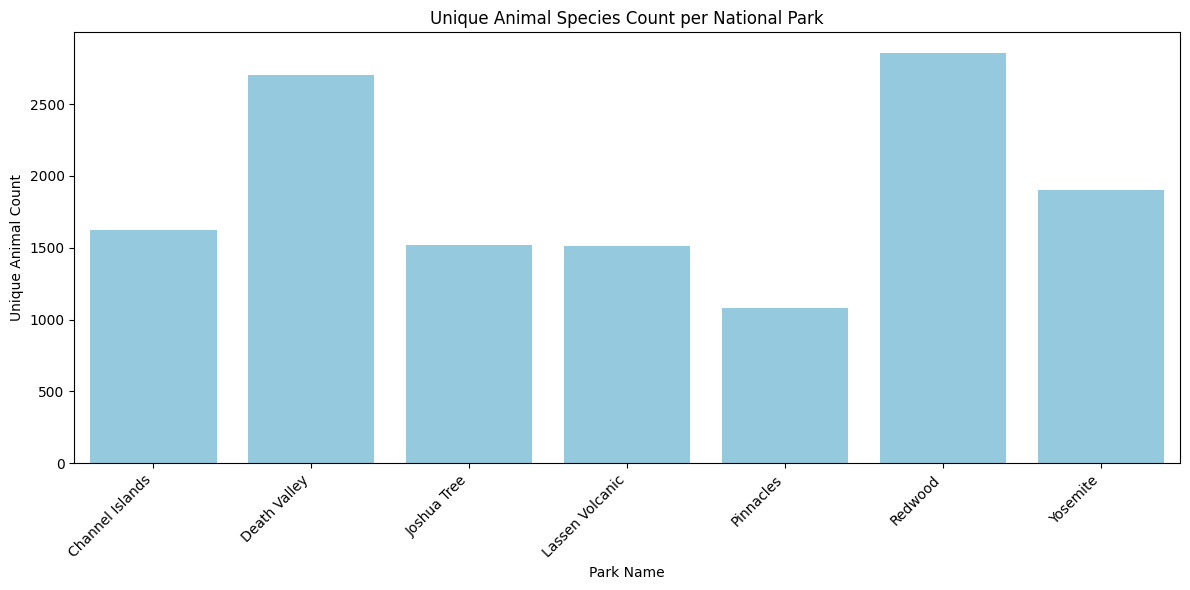

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count species by common name per park
common_name_counts = species_df.groupby(['Park Name'])['Common Names'].nunique().reset_index()
common_name_counts.rename(columns={'Common Names': 'Unique Animal Count'}, inplace=True)

# Calculate average footfall per park
avg_footfall = footfall_df.groupby('National Park')['Footfall'].mean().reset_index()
avg_footfall.rename(columns={'National Park': 'Park Name'}, inplace=True)

# Merge the datasets
merged_counts_footfall = pd.merge(common_name_counts, avg_footfall, on='Park Name', how='inner')

plt.figure(figsize=(12, 6))
sns.barplot(x='Park Name', y='Unique Animal Count', data=merged_counts_footfall, color='skyblue')
plt.title('Unique Animal Species Count per National Park')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [54]:
# Group species data by Park Name, Category, Year, Month and calculate species count and abundance
species_aggregated = species_df.groupby(['Park Name', 'Category']).agg({
    'Scientific Name': 'nunique',  # Count unique species
    'Abundance': 'sum',            # Sum of abundance for each category
}).reset_index()

# Rename columns for clarity
species_aggregated.rename(columns={'Scientific Name': 'Species Count'}, inplace=True)

# Display first few rows to verify aggregation
print(species_aggregated.head())

# Merge aggregated species data with footfall data
merged_df = pd.merge(species_aggregated, footfall_df, left_on=['Park Name'], right_on=['National Park'], how='inner')

# Calculate correlation only for numeric columns like Footfall and Species Count
species_footfall_correlation = merged_df[['Species Count', 'Footfall']].corr()
print("Correlation between Footfall and Species Count:")
print(species_footfall_correlation)



         Park Name             Category  Species Count  \
0  Channel Islands            Amphibian              4   
1  Channel Islands                 Bird            357   
2  Channel Islands            Chromista             61   
3  Channel Islands  Crab/Lobster/Shrimp             11   
4  Channel Islands                 Fish            273   

                                           Abundance  
0                               CommonUncommonCommon  
1  OccasionalOccasionalUncommonRareCommonOccasion...  
2                                                  0  
3                                             Common  
4  UncommonAbundantAbundantUncommonUncommonUncomm...  
Correlation between Footfall and Species Count:
               Species Count  Footfall
Species Count       1.000000  0.046274
Footfall            0.046274  1.000000


In [55]:
# Filter species where Abundance is 'Rare' or 'Uncommon'
filtered_species_df = species_df[species_df['Abundance'].isin(['Rare', 'Uncommon'])]

# Count rare and uncommon species separately
species_counts = filtered_species_df.groupby(['Park Name', 'Abundance']).size().unstack(fill_value=0)

# Rename columns for clarity
species_counts = species_counts.rename(columns={'Rare': 'Rare Species Count', 'Uncommon': 'Uncommon Species Count'})

# Reset index for merging
species_counts = species_counts.reset_index()

# Merge species counts with footfall data
merged_df = pd.merge(species_counts, footfall_df, left_on=['Park Name'],
                      right_on=['National Park'], how='inner')
# Compute correlation between footfall and both rare/uncommon species count
correlation_matrix = merged_df[['Rare Species Count', 'Uncommon Species Count', 'Footfall']].corr()

# Print the correlation matrix
print("Correlation between Footfall and Species Counts:")
print(correlation_matrix)



Correlation between Footfall and Species Counts:
                        Rare Species Count  Uncommon Species Count  Footfall
Rare Species Count                1.000000                0.794775  0.211411
Uncommon Species Count            0.794775                1.000000  0.388225
Footfall                          0.211411                0.388225  1.000000


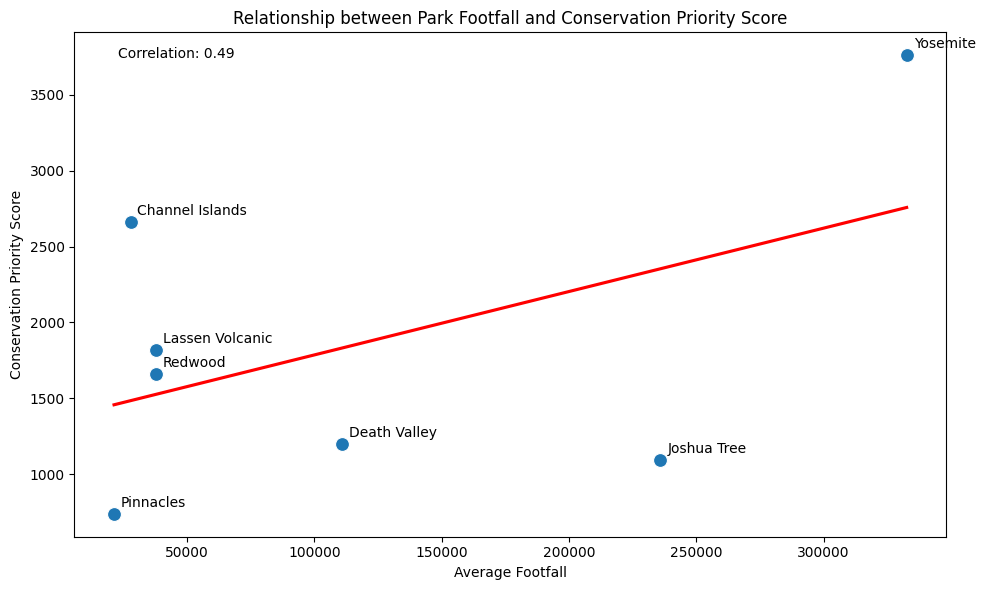

Correlation between conservation priority score and footfall: 0.49


In [56]:
# Group by Park Name, Category, and Abundance
category_abundance_counts = species_df.groupby(['Park Name', 'Category', 'Abundance']).size().reset_index(name='Count')

# Pivot the data to have categories as columns and abundance as values
pivot_data = category_abundance_counts.pivot_table(
    index=['Park Name', 'Category'],
    columns='Abundance',
    values='Count',
    fill_value=0
).reset_index()

# Check if specific abundance columns exist, if not create them
abundance_types = ['Rare', 'Uncommon', 'Common', 'Abundant']
for abundance in abundance_types:
    if abundance not in pivot_data.columns:
        pivot_data[abundance] = 0

# Create a 'Conservation Priority Score' - higher weight for rare and uncommon species
pivot_data['Conservation Score'] = (
    pivot_data['Rare'] * 4 +
    pivot_data['Uncommon'] * 2 +
    pivot_data['Common'] * 1 +
    pivot_data['Abundant'] * 0.5
)

# Aggregate to park level
park_conservation_score = pivot_data.groupby('Park Name')['Conservation Score'].sum().reset_index()

# Merge with footfall data
conservation_footfall = pd.merge(park_conservation_score, avg_footfall, on='Park Name', how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Footfall', y='Conservation Score', data=conservation_footfall, s=100)

# Add park names as annotations
for i, row in conservation_footfall.iterrows():
    plt.annotate(row['Park Name'], (row['Footfall'], row['Conservation Score']),
                 xytext=(5, 5), textcoords='offset points')

# Add regression line
sns.regplot(x='Footfall', y='Conservation Score', data=conservation_footfall,
            scatter=False, ci=None, line_kws={'color': 'red'})

corr_conservation = conservation_footfall['Footfall'].corr(conservation_footfall['Conservation Score'])
plt.annotate(f'Correlation: {corr_conservation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.title('Relationship between Park Footfall and Conservation Priority Score')
plt.xlabel('Average Footfall')
plt.ylabel('Conservation Priority Score')
plt.tight_layout()
plt.show()
print(f"Correlation between conservation priority score and footfall: {corr_conservation:.2f}")

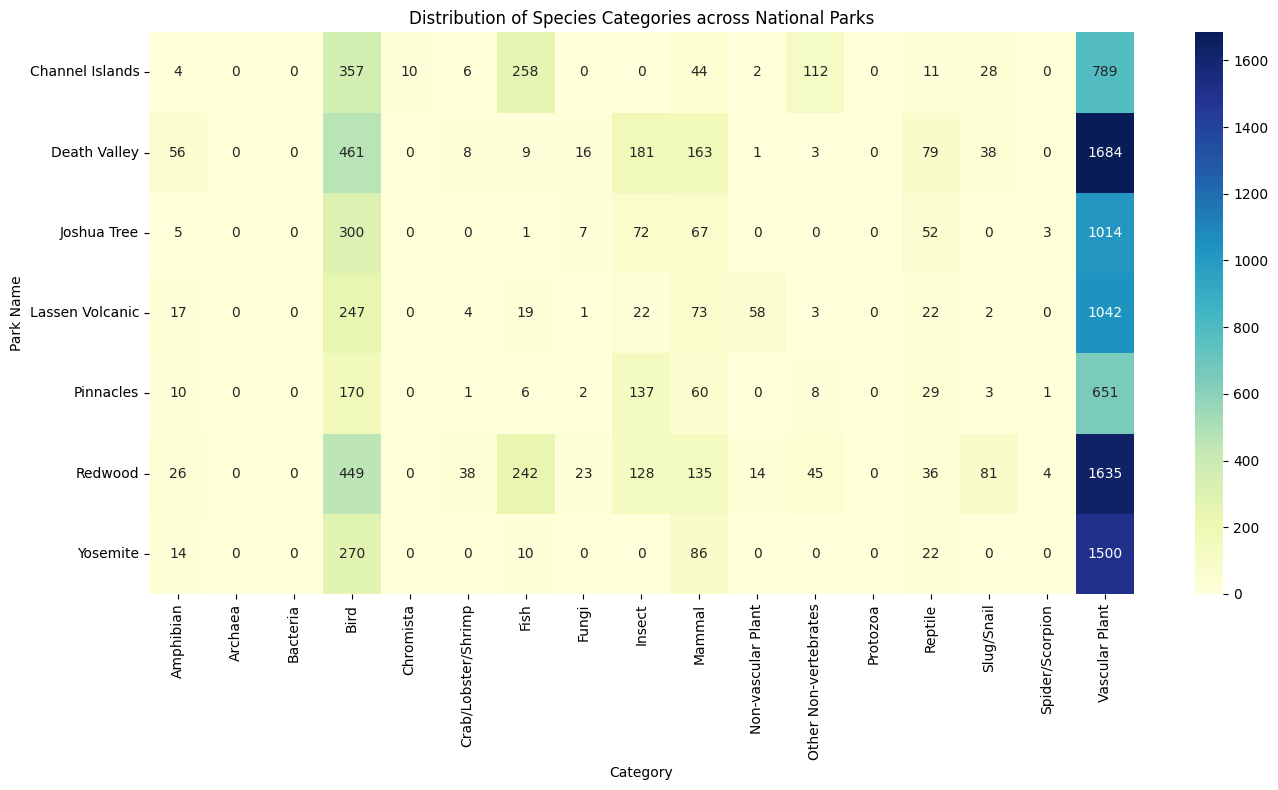

In [57]:
# Heatmap of species categories across parks
category_counts = species_df.groupby(['Park Name', 'Category'])['Common Names'].nunique().reset_index()
category_pivot = category_counts.pivot(index='Park Name', columns='Category', values='Common Names').fillna(0)

# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(category_pivot, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Distribution of Species Categories across National Parks')
plt.tight_layout()
plt.show()

In [59]:
# Calculate correlations between each category proportion and footfall
category_corrs = []
for category in top_categories:
    category_data = category_proportions[category_proportions['Category'] == category]
    corr = category_data['Proportion'].corr(category_data['Footfall'])
    category_corrs.append({'Category': category, 'Correlation': corr})

category_corrs_df = pd.DataFrame(category_corrs)
print("Correlations between category proportions and footfall:")
print(category_corrs_df)

Correlations between category proportions and footfall:
         Category  Correlation
0  Vascular Plant     0.765178
1            Bird    -0.229758
2          Mammal    -0.000637
3            Fish    -0.461293
4          Insect    -0.004604


In [60]:
# Summary and Findings
print("\nSummary of Key Findings:")
print(f"1. Correlation between unique animal count and footfall: {corr:.2f}")
print(f"2. Correlation between conservation priority score and footfall: {corr_conservation:.2f}")
print("3. Top categories by correlation with footfall:")
for i, row in category_corrs_df.sort_values('Correlation', ascending=False).iterrows():
    print(f"   - {row['Category']}: {row['Correlation']:.2f}")


Summary of Key Findings:
1. Correlation between unique animal count and footfall: -0.00
2. Correlation between conservation priority score and footfall: 0.49
3. Top categories by correlation with footfall:
   - Vascular Plant: 0.77
   - Mammal: -0.00
   - Insect: -0.00
   - Bird: -0.23
   - Fish: -0.46
